Training on 1449 samples with 2 features.
Starting Training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0350 - val_loss: 0.0167
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0216 - val_loss: 0.0118
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0196 - val_loss: 0.0116
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0198 - val_loss: 0.0116
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0196 - val_loss: 0.0114
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0198 - val_loss: 0.0113
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0192 - val_loss: 0.0113
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0195 - val_loss: 0.0114
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0189 - val_loss: 0.0112
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0195 - val_loss: 0.0111
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0188 - val_loss: 0.0111

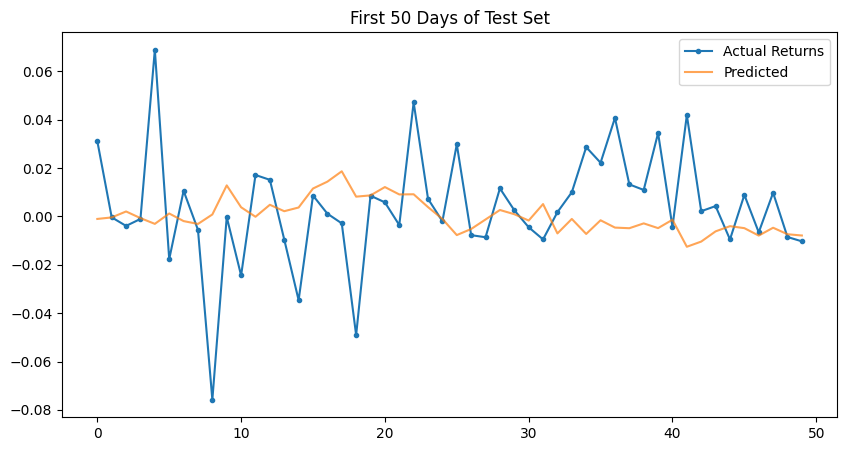

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib
import matplotlib.pyplot as plt

# 1. Load the New Stationary Data
X = np.load('../data/processed/X.npy')
y = np.load('../data/processed/y.npy')
scaler = joblib.load('../data/processed/scaler.pkl')

# 2. Split Data (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training on {X_train.shape[0]} samples with {X_train.shape[2]} features.")

# 3. Build Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Transformer Block 1
    x = transformer_encoder(x, head_size=128, num_heads=2, ff_dim=4, dropout=0.1)
    
    # Transformer Block 2 (Stacked for depth)
    x = transformer_encoder(x, head_size=128, num_heads=2, ff_dim=4, dropout=0.1)

    # Global Average Pooling (Flatten time)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    # MLP Head
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x) # Predicting 1 float (the Return)
    
    return models.Model(inputs, outputs)

# 4. Compile
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Low LR is key for Transformers
model.compile(loss="mean_squared_error", optimizer=optimizer)

# 5. Train
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 6. Evaluate
predictions = model.predict(X_test)

# Inverse Scale to get real %
def inverse_transform(predictions, scaler):
    dummy = np.zeros((len(predictions), 2))
    dummy[:, 0] = predictions.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

real_pred_returns = inverse_transform(predictions, scaler)
real_actual_returns = inverse_transform(y_test, scaler)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real_actual_returns, real_pred_returns)

print(f"\n--- Transformer Results (Returns) ---")
print(f"Transformer MAE: {mae:.5f}")
print(f"Baseline to Beat: 0.02033")

if mae < 0.02033:
    print("SUCCESS: The Transformer is predicting better than the baseline!")
else:
    print("ANALYSIS: Still struggling. Market noise is very high.")
    
# 7. Visual Check
plt.figure(figsize=(10, 5))
plt.plot(real_actual_returns[:50], label='Actual Returns', marker='.')
plt.plot(real_pred_returns[:50], label='Predicted', alpha=0.7)
plt.title("First 50 Days of Test Set")
plt.legend()
plt.show()